<div class="alert alert-block alert-success">
    
# FIT5196 Assessment 2
#### Student Name: Huangjin Wang
#### Student ID: 32189222

Date: 30-09-2022


Environment: Python 3.9

Libraries used:
* datetime (get date)
* pandas (for data manipulation) 
* numpy (for calculating IQR)
* matplotlib.pyplot (for ploting)
* networkx (for calculating shortest distance)
* sklearn.linear_model (for building linear regression model)
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Solution for dirty data](#dirty) <br>
[2. Imputing missing file](#missing) <br>
[3. Outlier processing](#outlier) <br>
[4. Output](#output) <br>

<div class="alert alert-block alert-warning">

## 1.  Solution for dirty data  <a class="anchor" name="dirty"></a>
    
</div>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from pandas import Series,DataFrame
import networkx as nx
from sklearn.linear_model import LinearRegression

In [2]:
dirty = pd.read_csv('32189222_dirty_data.csv')
# have a glance of the data
dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [3]:
dirty.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB02778,2021-08-12,15:26:11,Lunch,TP,"[('Fries', 4), ('Salad', 5), ('Steak', 4), ('C...",506.0,-37.800868,144.953573,0,9.896,13.130757
1,ORDC10788,2021-09-09,16:16:54,Dinner,NS,"[('Salmon', 10), ('Pasta', 4), ('Shrimp', 3)]",682.0,-37.824636,144.959284,0,9.578,16.092243
2,ORDB02495,2021-10-27,17:58:18,Dinner,TP,"[('Pasta', 10), ('Salmon', 9), ('Fish&Chips', ...",943.0,-37.814946,144.964766,0,7.985,12.462828
3,ORDY00086,2021-12-12,19:29:34,Dinner,TP,"[('Salmon', 6), ('Pasta', 10)]",521.0,-37.809747,144.963758,0,8.629,14.320767
4,ORDK07407,2021-27-02,09:51:32,Breakfast,BK,"[('Cereal', 5), ('Eggs', 7), ('Coffee', 3)]",263.5,-37.806327,145.009734,0,3.913,10.703636


###  Clean date
Firstly, check the wrong date in the data.

In [4]:
for date in dirty.date: 
    try: # check if the dates are in the format of YYYY-MM-DD
        datetime.strptime(date, '%Y-%m-%d')
    except: # print out the date, if date format is incorrect
        print(date)
# Reference
#https://theprogrammingexpert.com/check-if-string-is-date-in-python/#:~:text=You%20can%20check%20if%20a,the%20datetime%20object%20is%20created.

2021-27-02
2021-21-07
2021-17-09
2021-21-12
2021-Feb-04
2021-20-01


We can see the wrong date in the data. Then we can replace them by correct format.

In [5]:
dirty.date.replace({'2021-27-02': '2021-02-27',
                   '2021-21-07': '2021-07-21',
                   '2021-17-09': '2021-09-17',
                   '2021-21-12': '2021-12-21',
                   '2021-Feb-04': '2021-02-04',
                   '2021-20-01': '2021-01-20'},inplace = True)

In [6]:
# double check the date column
for date in dirty.date: 
    try:# check if the dates are in the format of YYYY-MM-DD
        datetime.strptime(date, '%Y-%m-%d')
    except:# print out the date, if date format is incorrect
        print(date)

Now these wrong dates are imputed to correct format.

### Clean order type

Change all the order type based on the order time, this will replace possible wrong order type.

In [7]:
for index,row in dirty.iterrows():
    if row.time <= '12:00:00': 
        # if time is earlier than 12:00:01, it is breakfast
        dirty.loc[index,'order_type'] = 'Breakfast'
        continue
    if row.time >= '12:00:01' and row.time <='16:00:00' :
        # if time is later than 12:00:00 and earlier than 16:00:01, it is lunch
        dirty.loc[index,'order_type'] = 'Lunch'
        continue
    if row.time >= '16:00:01' and row.time <='20:00:00':
        # if time is later than 16:00:00 and earlier than 20:00:01, it is dinner
        dirty.loc[index,'order_type'] = 'Dinner'
        continue

### Clean branch_code

In [8]:
# check branch_code values
dirty.branch_code.value_counts()

NS    174
TP    167
BK    154
tp      3
ns      1
bk      1
Name: branch_code, dtype: int64

From the values of branch code, we can see that values are inconsistent. e.g. `'TP'` and `'tp'`, `'NS'` and `'ns'`, `'BK'` and `'bk'`.

In [9]:
# Upper all the values in branch code
dirty.branch_code = dirty['branch_code'].apply(lambda code: code.upper())

In [10]:
# check values after cleaning
dirty.branch_code.value_counts()

NS    175
TP    170
BK    155
Name: branch_code, dtype: int64

In [11]:
pd.crosstab(dirty.order_id.str.slice(0,4),dirty.branch_code)

branch_code,BK,NS,TP
order_id,,,
ORDA,57,0,2
ORDB,1,0,58
ORDC,1,60,0
ORDI,0,58,0
ORDJ,0,0,52
ORDK,53,0,1
ORDX,43,0,0
ORDY,0,0,57
ORDZ,0,57,0


However, from the cross table of order_id and branch_code, the first four letters of order id is related to the branch code. e.g. `ORDA` relat to `BK`. Thus, There are some wrong relations in our data, `ORDA` has 2 incorrect values of `TP`, `ORDB` has an incorrect value `BK`, `ORDK` has an incorrect value `TP`, `ORDC` has an incorrect value `BK`.

We just need to change all branch code values based on their first four letters of order id.

In [12]:
for index,row in dirty.iterrows():
    if dirty.order_id[index].startswith('ORDA'):
        # if it starts with ORDA, change branch code to BK
        dirty.loc[index,'branch_code'] = 'BK'
        continue
    if dirty.order_id[index].startswith('ORDB'):
        # if it starts with ORDB, change branch code to TP
        dirty.loc[index,'branch_code'] = 'TP'
        continue
    if dirty.order_id[index].startswith('ORDC'):
        # if it starts with ORDC, change branch code to NS
        dirty.loc[index,'branch_code'] = 'NS'
        continue
    if dirty.order_id[index].startswith('ORDK'):
        # if it starts with ORDK, change branch code to TP
        dirty.loc[index,'branch_code'] = 'TP'
        continue

In [13]:
# check cross table after cleaning
pd.crosstab(dirty.order_id.str.slice(0,4),dirty.branch_code)

branch_code,BK,NS,TP
order_id,,,
ORDA,59,0,0
ORDB,0,0,59
ORDC,0,61,0
ORDI,0,58,0
ORDJ,0,0,52
ORDK,0,0,54
ORDX,43,0,0
ORDY,0,0,57
ORDZ,0,57,0


Now, all the order_ids have their correct branch codes.

### Clean customer lat and lon

In [14]:
dirty.customer_lat.describe()

count    500.000000
mean     -35.379544
std       19.357605
min      -37.827562
25%      -37.818595
50%      -37.812703
75%      -37.805741
max      144.995138
Name: customer_lat, dtype: float64

In [15]:
dirty.customer_lon.describe()

count    500.000000
mean     143.140142
std       18.205197
min      -37.826094
25%      144.950383
50%      144.964247
75%      144.983486
max      145.018407
Name: customer_lon, dtype: float64

By using `describe` funciton, we can see some values in customer lat are actually customer lon. However, some values in customer lon are customer lat. e.g. most of customer lat are negative numbers, but there are some positive numbers in customer lat. And most of customer lon are positive numbers also invovles negative numbers.

In [16]:
wrong_lat = []
wrong_lon = []
for index, row in dirty.iterrows():
    if dirty.loc[index,'customer_lat'] > 0:
        wrong_lat.append(index)
    if dirty.loc[index,'customer_lon'] < 0 :
        wrong_lon.append(index)

In [17]:
wrong_lat

[16, 36, 150, 237, 287, 378, 446, 485, 490]

In [18]:
wrong_lon

[16, 287, 378, 446, 485]

In [19]:
dirty.iloc[wrong_lat,[7,8]]

,customer_lat,customer_lon
16,144.951423,-37.817905
36,37.805444,144.983608
150,37.815669,144.958213
237,37.802222,144.963332
287,144.983443,-37.824205
378,144.995138,-37.826094
446,144.990883,-37.812003
485,144.988566,-37.809320
490,37.812235,144.989870


From these wrong records, we can see that some values are swaped between `lat` and `lon`, like row 16. However, some values in lat should be negative such as `37.805444`, as others are negative 37 something. Thus, what we need to do is swap the lat and lon for these rows and change values to negative for those who are positive. For swaping lat and lon, we need to make two another copies of origional data to change value. 

In [20]:
sub_lat = dirty.iloc[wrong_lon,7].copy() # copy of origional lat data
sub_lon = dirty.iloc[wrong_lon,8].copy() # copy of origional lon data

In [21]:
sub_lat

16     144.951423
287    144.983443
378    144.995138
446    144.990883
485    144.988566
Name: customer_lat, dtype: float64

In [22]:
sub_lon

16    -37.817905
287   -37.824205
378   -37.826094
446   -37.812003
485   -37.809320
Name: customer_lon, dtype: float64

In [23]:
dirty.iloc[wrong_lon,7] = sub_lon # swap lat and lon 
dirty.iloc[wrong_lon,8] = sub_lat # swap lon and lat

In [24]:
dirty.iloc[wrong_lat,[7,8]] # check lon after swap

,customer_lat,customer_lon
16,-37.817905,144.951423
36,37.805444,144.983608
150,37.815669,144.958213
237,37.802222,144.963332
287,-37.824205,144.983443
378,-37.826094,144.995138
446,-37.812003,144.990883
485,-37.809320,144.988566
490,37.812235,144.989870


Now, there is one more step to go, change positive lat to negative. 

In [25]:
# change all the lat value to positive and mutiply -1
dirty.customer_lat = abs(dirty.customer_lat) *-1

In [26]:
dirty.iloc[wrong_lat,[7,8]] # check after cleaning

,customer_lat,customer_lon
16,-37.817905,144.951423
36,-37.805444,144.983608
150,-37.815669,144.958213
237,-37.802222,144.963332
287,-37.824205,144.983443
378,-37.826094,144.995138
446,-37.812003,144.990883
485,-37.809320,144.988566
490,-37.812235,144.989870


Now, all customer lat and lon values are in the correct format.

### Clean distance to customer

Since we have lat and lon for both customer and branch, we can use Dijkstra algorithm to calculate the shorest distance between customer and branch. Thus, we can validate if values are correct. First, we need to know node for branches and customers, then create a graph to store every node and edge, and implement dijkstra algorithm to calculate the shortest distance between order branches and customers eventually.

In [27]:
nodes = pd.read_csv('nodes.csv') # read nodes 
edges = pd.read_csv('edges.csv') # read edges
branches = pd.read_csv('branches.csv') # read branches

In [28]:
nodes.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In [29]:
edges.head()

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


In [30]:
branches.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


We already have branches and corresponding lat and lon. Thus,we can find their node.

In [31]:
for index,row in nodes.iterrows():
    if row.lat == branches.loc[0,'branch_lat'] and row.lon == branches.loc[0,'branch_lon']:
        NS_node = int(row.node)
        continue
    if row.lat == branches.loc[1,'branch_lat'] and row.lon == branches.loc[1,'branch_lon']:
        TP_node = int(row.node)
        continue
    if row.lat == branches.loc[2,'branch_lat'] and row.lon == branches.loc[2,'branch_lon']:
        BK_node = int(row.node)
        continue

In [32]:
# join branch code and their lat,lon and node together
branch_node = pd.concat([branches,DataFrame({'node': [NS_node,TP_node,BK_node]})],axis = 1)
branch_node

,branch_code,branch_name,branch_lat,branch_lon,node
0,NS,Nickolson,-37.773803,144.983647,2455254505
1,TP,Thompson,-37.861835,144.905716,1390575046
2,BK,Bakers,-37.815834,145.046450,1889485053


In [33]:
# remove unnecessary column and remove columns
branch_node = branch_node.drop('branch_name',axis = 1)
branch_node.columns =['branch_code','branch_lat', 'branch_lon', 'branch_node']

In [34]:
branch_node

,branch_code,branch_lat,branch_lon,branch_node
0,NS,-37.773803,144.983647,2455254505
1,TP,-37.861835,144.905716,1390575046
2,BK,-37.815834,145.046450,1889485053


Now, we have branch code and corresponding lat, lon and node. Next, we will get node for each customer.

In [35]:
# get customers' lat and lon and order branch
customer = dirty[['order_id','customer_lat','customer_lon','branch_code']]
customer.columns = ['order_id', 'lat', 'lon','branch_code']
customer

,order_id,lat,lon,branch_code
0,ORDB02778,-37.800868,144.953573,TP
1,ORDC10788,-37.824636,144.959284,NS
2,ORDB02495,-37.814946,144.964766,TP
3,ORDY00086,-37.809747,144.963758,TP
4,ORDK07407,-37.806327,145.009734,TP
...,...,...,...,...
495,ORDJ10864,-37.813801,144.926999,TP
496,ORDY09531,-37.811401,144.973216,TP
497,ORDC00751,-37.816927,144.931781,NS
498,ORDA08937,-37.809332,144.973121,BK


In [36]:
# find customer's node by joining nodes data frame and customer data frame
customer_node = customer.merge(nodes,how = 'left', on = ['lat','lon'])
# rename columns for later process
customer_node.columns = ['order_id', 'cus_lat','cus_lon','branch_code', 'cus_node']
customer_node

,order_id,cus_lat,cus_lon,branch_code,cus_node
0,ORDB02778,-37.800868,144.953573,TP,2096325804
1,ORDC10788,-37.824636,144.959284,NS,2696097098
2,ORDB02495,-37.814946,144.964766,TP,4391710425
3,ORDY00086,-37.809747,144.963758,TP,6167289289
4,ORDK07407,-37.806327,145.009734,TP,299024277
...,...,...,...,...,...
495,ORDJ10864,-37.813801,144.926999,TP,581703032
496,ORDY09531,-37.811401,144.973216,TP,588236766
497,ORDC00751,-37.816927,144.931781,NS,306968252
498,ORDA08937,-37.809332,144.973121,BK,3419354751


We have nodes for both customers and branches in different data frame. Then join two data frame for implementing shortest distance calculation.

In [37]:
# Join two dataframes by common column 'branch_code'
all_node = customer_node.merge(branch_node,how = 'left', on = 'branch_code')
all_node

,order_id,cus_lat,cus_lon,branch_code,cus_node,branch_lat,branch_lon,branch_node
0,ORDB02778,-37.800868,144.953573,TP,2096325804,-37.861835,144.905716,1390575046
1,ORDC10788,-37.824636,144.959284,NS,2696097098,-37.773803,144.983647,2455254505
2,ORDB02495,-37.814946,144.964766,TP,4391710425,-37.861835,144.905716,1390575046
3,ORDY00086,-37.809747,144.963758,TP,6167289289,-37.861835,144.905716,1390575046
4,ORDK07407,-37.806327,145.009734,TP,299024277,-37.861835,144.905716,1390575046
...,...,...,...,...,...,...,...,...
495,ORDJ10864,-37.813801,144.926999,TP,581703032,-37.861835,144.905716,1390575046
496,ORDY09531,-37.811401,144.973216,TP,588236766,-37.861835,144.905716,1390575046
497,ORDC00751,-37.816927,144.931781,NS,306968252,-37.773803,144.983647,2455254505
498,ORDA08937,-37.809332,144.973121,BK,3419354751,-37.815834,145.046450,1889485053


Then we need to create a graph to calculate the shortest distance.

In [38]:
# Crate a graph to for calculating shortest path
graph = nx.Graph()
# Add nodes
for node in nodes.node:
    graph.add_node(node)

# Add edges
for index,row in edges.iterrows():
    graph.add_edge(row.u,row.v, weight = row['distance(m)']) #(first node, second node, weight)

    
# Reference
# https://networkx.org/documentation/stable/reference/classes/graph.html

In [39]:
short_distance = [] # calculated shortest distance used for updating wrong distance
wrong_distance = [] # index of wrong distance in the data
# Calculate shortest distance by dijstra algorithm
for index,row in all_node.iterrows():
    distance = nx.algorithms.shortest_paths.generic.shortest_path_length(graph,
                                                                        source = row['cus_node'],
                                                                        target = row['branch_node'],
                                                                         weight = 'weight',
                                                                        method = 'dijkstra')
    distance = round(distance/1000,3) # change m to km
    short_distance.append(distance)
    # if recorded distance is wrong, then record its index
    if distance != dirty.loc[index, 'distance_to_customer_KM']: 
        wrong_distance.append(index)
# Reference
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html

In [40]:
# Show the calculated distance
short_distance_df = pd.DataFrame(short_distance, columns = ['short_distance'])
short_distance_df

,short_distance
0,9.896
1,9.578
2,7.985
3,8.629
4,12.348
...,...
495,12.199
496,8.849
497,9.425
498,6.634


In [41]:
# show the row indexs which values is wrong
wrong_distance

[4,
 9,
 10,
 26,
 30,
 44,
 45,
 47,
 52,
 62,
 66,
 74,
 82,
 93,
 97,
 102,
 106,
 111,
 125,
 128,
 132,
 135,
 139,
 165,
 183,
 199,
 204,
 207,
 228,
 231,
 238,
 248,
 252,
 257,
 259,
 265,
 266,
 277,
 286,
 290,
 296,
 297,
 299,
 300,
 303,
 308,
 331,
 332,
 358,
 374,
 393,
 401,
 402,
 406,
 416,
 420,
 431,
 442,
 447,
 452,
 455,
 464,
 475]

In [42]:
# Show the wrong distance values
dirty.iloc[wrong_distance,-2]

4      3.913
9      7.187
10     5.133
26     3.502
30     5.422
       ...  
447    8.001
452    7.380
455    7.120
464    9.291
475    5.308
Name: distance_to_customer_KM, Length: 63, dtype: float64

In [43]:
# change the wrong distance by calculated shortest distance
dirty.iloc[wrong_distance,-2] = short_distance_df.iloc[wrong_distance,0]

In [44]:
# show the wrong part after cleaning
dirty.iloc[wrong_distance,-2]

4      12.348
9       9.066
10     12.720
26     11.649
30      9.834
        ...  
447     9.847
452    10.232
455     9.408
464     8.860
475    10.294
Name: distance_to_customer_KM, Length: 63, dtype: float64

Now, all the values of shortest distance to customer are correct.

# Clean customer loyalty

We can use delivery fee to validate if customer has loyalty since delivery fee column is error free. However, delivery fee is influenced by some other factors such as weekend or weekday and time of the day. We need to get these two factors for each order first. Then we can use delivery fee to calculate the 

In [45]:
weekend = [] # to store if the date is weekend or not
for index, row in dirty.iterrows():
    # get date
    date = datetime.strptime(row.date, '%Y-%m-%d')
    if date.isoweekday() <= 5: # if day is 1,2,3,4,5, it is the weekday
        weekend.append('0')
    else: # otherwise, it is the weekend
        weekend.append('1')

In [46]:
weekend = pd.DataFrame(weekend, columns = ['is_weekend']) # concat dataframes for later process
weekend

,is_weekend
0,0
1,0
2,0
3,1
4,1
...,...
495,0
496,0
497,0
498,1


In [47]:
dirty = pd.concat([dirty, weekend], axis =1) # concat dataframes for later process
dirty

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend
0,ORDB02778,2021-08-12,15:26:11,Lunch,TP,"[('Fries', 4), ('Salad', 5), ('Steak', 4), ('C...",506.0,-37.800868,144.953573,0,9.896,13.130757,0
1,ORDC10788,2021-09-09,16:16:54,Dinner,NS,"[('Salmon', 10), ('Pasta', 4), ('Shrimp', 3)]",682.0,-37.824636,144.959284,0,9.578,16.092243,0
2,ORDB02495,2021-10-27,17:58:18,Dinner,TP,"[('Pasta', 10), ('Salmon', 9), ('Fish&Chips', ...",943.0,-37.814946,144.964766,0,7.985,12.462828,0
3,ORDY00086,2021-12-12,19:29:34,Dinner,TP,"[('Salmon', 6), ('Pasta', 10)]",521.0,-37.809747,144.963758,0,8.629,14.320767,1
4,ORDK07407,2021-02-27,09:51:32,Breakfast,TP,"[('Cereal', 5), ('Eggs', 7), ('Coffee', 3)]",263.5,-37.806327,145.009734,0,12.348,10.703636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDJ10864,2021-04-27,11:53:14,Breakfast,TP,"[('Cereal', 2), ('Eggs', 3), ('Coffee', 10)]",158.0,-37.813801,144.926999,0,12.199,14.718053,0
496,ORDY09531,2021-05-04,12:03:22,Lunch,TP,"[('Chicken', 10), ('Burger', 1), ('Steak', 1),...",420.0,-37.811401,144.973216,0,8.849,12.380880,0
497,ORDC00751,2021-03-03,10:01:41,Breakfast,NS,"[('Cereal', 9), ('Coffee', 1)]",185.5,-37.816927,144.931781,0,9.425,14.385538,0
498,ORDA08937,2021-10-09,17:17:44,Dinner,BK,"[('Pasta', 2), ('Shrimp', 2), ('Salmon', 4), (...",467.0,-37.809332,144.973121,0,6.634,16.551845,1


In [48]:
time_of_the_day = [] # to store time of the day
for index, row in dirty.iterrows():
    if row.order_type == 'Breakfast': # if it is Morning, then 0
        time_of_the_day.append('0')
        continue
    if row.order_type == 'Lunch':   # if it is Afternoon, then 1
        time_of_the_day.append('1')
        continue
    if row.order_type == 'Dinner': # if it is Evevning, then 2
        time_of_the_day.append('2')
        continue

In [49]:
time_of_the_day = pd.DataFrame(time_of_the_day, columns = ['time_of_the_day'])
time_of_the_day

,time_of_the_day
0,1
1,2
2,2
3,2
4,0
...,...
495,0
496,1
497,0
498,2


In [50]:
dirty = pd.concat([dirty, time_of_the_day], axis =1) # concat dataframes for later process
dirty

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,time_of_the_day
0,ORDB02778,2021-08-12,15:26:11,Lunch,TP,"[('Fries', 4), ('Salad', 5), ('Steak', 4), ('C...",506.0,-37.800868,144.953573,0,9.896,13.130757,0,1
1,ORDC10788,2021-09-09,16:16:54,Dinner,NS,"[('Salmon', 10), ('Pasta', 4), ('Shrimp', 3)]",682.0,-37.824636,144.959284,0,9.578,16.092243,0,2
2,ORDB02495,2021-10-27,17:58:18,Dinner,TP,"[('Pasta', 10), ('Salmon', 9), ('Fish&Chips', ...",943.0,-37.814946,144.964766,0,7.985,12.462828,0,2
3,ORDY00086,2021-12-12,19:29:34,Dinner,TP,"[('Salmon', 6), ('Pasta', 10)]",521.0,-37.809747,144.963758,0,8.629,14.320767,1,2
4,ORDK07407,2021-02-27,09:51:32,Breakfast,TP,"[('Cereal', 5), ('Eggs', 7), ('Coffee', 3)]",263.5,-37.806327,145.009734,0,12.348,10.703636,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDJ10864,2021-04-27,11:53:14,Breakfast,TP,"[('Cereal', 2), ('Eggs', 3), ('Coffee', 10)]",158.0,-37.813801,144.926999,0,12.199,14.718053,0,0
496,ORDY09531,2021-05-04,12:03:22,Lunch,TP,"[('Chicken', 10), ('Burger', 1), ('Steak', 1),...",420.0,-37.811401,144.973216,0,8.849,12.380880,0,1
497,ORDC00751,2021-03-03,10:01:41,Breakfast,NS,"[('Cereal', 9), ('Coffee', 1)]",185.5,-37.816927,144.931781,0,9.425,14.385538,0,0
498,ORDA08937,2021-10-09,17:17:44,Dinner,BK,"[('Pasta', 2), ('Shrimp', 2), ('Salmon', 4), (...",467.0,-37.809332,144.973121,0,6.634,16.551845,1,2


Now, we need to use missing_date to create a linear regression model as it contains correct data. Then, the missing data will be the training set, and apply the prediction to the delivery fee of dirty data.

In [51]:
missing = pd.read_csv('32189222_missing_data.csv')
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              450 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


As missing data have NA value, we need to drop the NA value.

In [52]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              450 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [53]:
# drop Na value for delivery fee column
missing = missing.dropna(subset = ['delivery_fee'], axis = 0) 
missing = missing.reset_index(drop = True)
missing

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03599,2021-12-12,19:29:34,Dinner,BK,"[('Fish&Chips', 5), ('Salmon', 7), ('Pasta', 10)]",737.00,-37.810456,144.961344,0,7.640,17.340778
1,ORDJ04126,2021-03-20,10:32:06,Breakfast,TP,"[('Pancake', 8), ('Cereal', 8)]",338.00,-37.808851,144.928945,0,11.180,14.181602
2,ORDB02151,2021-05-30,12:54:05,Lunch,TP,"[('Fries', 10), ('Burger', 5), ('Chicken', 3),...",630.40,-37.805314,144.941677,0,10.356,15.100696
3,ORDC09401,2021-05-23,12:43:56,Lunch,NS,"[('Chicken', 3), ('Steak', 8), ('Salad', 10)]",628.00,-37.814064,144.939691,0,9.644,17.083359
4,ORDJ08371,2021-12-23,19:49:51,Dinner,TP,"[('Salmon', 6), ('Shrimp', 4), ('Fish&Chips', 2)]",532.00,-37.809563,144.957517,0,8.909,12.910662
...,...,...,...,...,...,...,...,...,...,...,...,...
395,ORDZ10350,2021-09-17,16:37:10,Dinner,NS,"[('Fish&Chips', 4), ('Pasta', 1), ('Shrimp', 7)]",545.50,-37.801885,145.001950,0,9.176,15.138348
396,ORDB00466,2021-03-23,10:42:15,Breakfast,TP,"[('Cereal', 1), ('Coffee', 5), ('Pancake', 9),...",457.75,-37.803873,144.947910,0,9.916,12.044835
397,ORDC08364,2021-04-16,11:22:49,Breakfast,NS,"[('Eggs', 9), ('Coffee', 5), ('Cereal', 6), ('...",403.25,-37.824226,144.986689,0,9.484,14.219871
398,ORDZ03973,2021-06-08,13:14:21,Lunch,NS,"[('Steak', 6), ('Chicken', 4), ('Salad', 10), ...",904.00,-37.816425,144.945871,0,9.293,14.925156


Also, we need to add those information,if it is weekend and time of the day to the dataframe.

In [54]:
weekend = [] # to store if the date is weekend or not
for index, row in missing.iterrows():
    # get date
    date = datetime.strptime(row.date,'%Y-%m-%d')
    if date.isoweekday() <= 5: # if day is 1,2,3,4,5, it is the weekday
        weekend.append('0')
    else: # otherwise, it is the weekend
        weekend.append('1')
time_of_the_day = [] # to store time of the day
for index, row in missing.iterrows():
    if row.order_type == 'Breakfast': # if it is Morning, then 0
        time_of_the_day.append('0')
        continue
    if row.order_type == 'Lunch':   # if it is Afternoon, then 1
        time_of_the_day.append('1')
        continue
    if row.order_type == 'Dinner': # if it is Evevning, then 2
        time_of_the_day.append('2')
        continue

In [55]:
time_of_the_day = pd.DataFrame(time_of_the_day, columns = ['time_of_the_day'])
weekend = pd.DataFrame(weekend, columns = ['is_weekend'])

missing = pd.concat([missing, weekend,time_of_the_day],axis =1) # concat dataframe
missing.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,time_of_the_day
0,ORDA03599,2021-12-12,19:29:34,Dinner,BK,"[('Fish&Chips', 5), ('Salmon', 7), ('Pasta', 10)]",737.0,-37.810456,144.961344,0,7.640,17.340778,1,2
1,ORDJ04126,2021-03-20,10:32:06,Breakfast,TP,"[('Pancake', 8), ('Cereal', 8)]",338.0,-37.808851,144.928945,0,11.180,14.181602,1,0
2,ORDB02151,2021-05-30,12:54:05,Lunch,TP,"[('Fries', 10), ('Burger', 5), ('Chicken', 3),...",630.4,-37.805314,144.941677,0,10.356,15.100696,1,1
3,ORDC09401,2021-05-23,12:43:56,Lunch,NS,"[('Chicken', 3), ('Steak', 8), ('Salad', 10)]",628.0,-37.814064,144.939691,0,9.644,17.083359,1,1
4,ORDJ08371,2021-12-23,19:49:51,Dinner,TP,"[('Salmon', 6), ('Shrimp', 4), ('Fish&Chips', 2)]",532.0,-37.809563,144.957517,0,8.909,12.910662,0,2


Now, we can build linear regression model for each branch, first we need to split missing data by branch code before we can do build the LR model.

In [56]:
bk_missing = missing[missing.branch_code == 'BK'] # For which branch code is bk
tp_missing = missing[missing.branch_code == 'TP'] # For which branch code is tp
ns_missing = missing[missing.branch_code == 'NS'] # For which branch code is ns

Now, we can build LR model for delivery fee based on difference branch.

In [57]:
bk_lm = LinearRegression() 
tp_lm = LinearRegression()
ns_lm = LinearRegression()

In [58]:
# for each branch
# make prediction for delivery fee based on is weekend, time of the day, and distance to customer
bk_lm.fit(bk_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']], 
          bk_missing['delivery_fee'])
tp_lm.fit(tp_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']], 
          tp_missing['delivery_fee'])
ns_lm.fit(ns_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']], 
          ns_missing['delivery_fee'])

LinearRegression()

In [59]:
# create an empty column to store predicted fee later
dirty['predict_fee'] = 0

In [60]:
# split dirty data based on different branch
# Since we need to build LR model for each branch
bk_dirty = dirty[dirty.branch_code == 'BK']
tp_dirty = dirty[dirty.branch_code == 'TP']
ns_dirty = dirty[dirty.branch_code == 'NS']

In [61]:
# for each branch
# Make prediction for dirty data based on training data set, which is the missing data
bk_dirty['predict_fee'] = bk_lm.predict(bk_dirty[['is_weekend','time_of_the_day','distance_to_customer_KM']])
tp_dirty['predict_fee'] = tp_lm.predict(tp_dirty[['is_weekend','time_of_the_day','distance_to_customer_KM']])
ns_dirty['predict_fee'] = ns_lm.predict(ns_dirty[['is_weekend','time_of_the_day','distance_to_customer_KM']])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19980\588874686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_dirty['predict_fee'] = bk_lm.predict(bk_dirty[['is_weekend','time_of_the_day','distance_to_customer_KM']])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19980\588874686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_dirty['predict_fee'] = tp_lm.predict(tp_dirty[['is_weekend','time_of_the_day','distance_to_customer_KM']])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_

Now, we have the predicted fee for each branch, we can add these predicted value to the dirty data.

In [62]:
# based on the index, add predicted fee for each record
for index,row in bk_dirty.iterrows():
    dirty.iloc[index,-1] = row.predict_fee
for index,row in tp_dirty.iterrows():
    dirty.iloc[index,-1] = row.predict_fee
for index,row in ns_dirty.iterrows():
    dirty.iloc[index,-1] = row.predict_fee

In [63]:
dirty.head() # check after prediction

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,time_of_the_day,predict_fee
0,ORDB02778,2021-08-12,15:26:11,Lunch,TP,"[('Fries', 4), ('Salad', 5), ('Steak', 4), ('C...",506.0,-37.800868,144.953573,0,9.896,13.130757,0,1,12.870347
1,ORDC10788,2021-09-09,16:16:54,Dinner,NS,"[('Salmon', 10), ('Pasta', 4), ('Shrimp', 3)]",682.0,-37.824636,144.959284,0,9.578,16.092243,0,2,15.499899
2,ORDB02495,2021-10-27,17:58:18,Dinner,TP,"[('Pasta', 10), ('Salmon', 9), ('Fish&Chips', ...",943.0,-37.814946,144.964766,0,7.985,12.462828,0,2,12.503924
3,ORDY00086,2021-12-12,19:29:34,Dinner,TP,"[('Salmon', 6), ('Pasta', 10)]",521.0,-37.809747,144.963758,0,8.629,14.320767,1,2,14.488519
4,ORDK07407,2021-02-27,09:51:32,Breakfast,TP,"[('Cereal', 5), ('Eggs', 7), ('Coffee', 3)]",263.5,-37.806327,145.009734,0,12.348,10.703636,1,0,15.136292


In [64]:
wrong_loyalty = []
for index,row in dirty.iterrows():
    if row.predict_fee * 0.5 < row.delivery_fee  and row['customerHasloyalty?'] == 1:
        wrong_loyalty.append(index)
        continue
    if row.predict_fee *0.5 > row.delivery_fee and row['customerHasloyalty?'] == 0:
        wrong_loyalty.append(index)

In [65]:
dirty.iloc[wrong_loyalty,[-6,-4,-1]]

,customerHasloyalty?,delivery_fee,predict_fee
15,1,5.799415,10.814247
25,1,15.192752,14.092457
46,1,7.465220,14.887404
65,1,7.040820,12.862441
71,1,14.715644,14.136724
85,1,7.441610,14.184793
98,1,6.899432,12.837530
102,1,7.157712,13.324640
130,1,8.024561,15.388274
145,1,12.468010,12.441417


Since we predicted the delivery fee, it may have som bias between real fee, we need to filter this wrong index again, which indexs we just got. Also, we can see that from the wrong customer loyalty, all value is 1, so we need to remove indexs that half of the predicted fee has small difference when compare to real delivery fee.

In [66]:
new_wrong_loyalty = []
for i in wrong_loyalty:
    predict = dirty.loc[i,'predict_fee']
    true = dirty.loc[i,'delivery_fee']
    if abs(predict*0.5 - true) > 2:
        new_wrong_loyalty.append(i)

In [67]:
dirty.iloc[new_wrong_loyalty,[-6,-4,-1]]

,customerHasloyalty?,delivery_fee,predict_fee
25,1,15.192752,14.092457
71,1,14.715644,14.136724
145,1,12.468010,12.441417
154,1,16.838401,16.857519
409,1,14.792059,14.094411
427,1,13.265488,12.280702
450,1,12.912574,11.883032


Now, we have our final wrong record, since the difference between predict_fee and delivery_fee is small, which can be caused by prediction bias. And apparently these customers are not loyal.

In [68]:
dirty.iloc[new_wrong_loyalty,-6] = 0

In [69]:
dirty.iloc[new_wrong_loyalty,-6] # check after cleaning

25     0
71     0
145    0
154    0
409    0
427    0
450    0
Name: customerHasloyalty?, dtype: int64

Thus, the cleaning for dirty_data file is done.

<div class="alert alert-block alert-warning">
    
## 2.  Imputing missing file  <a class="anchor" name="missing"></a>
 </div>

In [70]:
missing = pd.read_csv('32189222_missing_data.csv') # read missing data again

In [71]:
missing.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA03599,2021-12-12,19:29:34,Dinner,BK,"[('Fish&Chips', 5), ('Salmon', 7), ('Pasta', 10)]",737.0,-37.810456,144.961344,0,7.640,17.340778
1,ORDJ04126,2021-03-20,10:32:06,Breakfast,TP,"[('Pancake', 8), ('Cereal', 8)]",338.0,-37.808851,144.928945,0,11.180,14.181602
2,ORDB02151,2021-05-30,12:54:05,Lunch,TP,"[('Fries', 10), ('Burger', 5), ('Chicken', 3),...",630.4,-37.805314,144.941677,0,10.356,15.100696
3,ORDC09401,2021-05-23,12:43:56,Lunch,NS,"[('Chicken', 3), ('Steak', 8), ('Salad', 10)]",628.0,-37.814064,144.939691,0,9.644,17.083359
4,ORDJ08371,2021-12-23,19:49:51,Dinner,TP,"[('Salmon', 6), ('Shrimp', 4), ('Fish&Chips', 2)]",532.0,-37.809563,144.957517,0,8.909,12.910662


In [72]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              450 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


As we can see, there should be 500 rows in the missing file, however, the branch_code has only 450 rows, and delivery_fee has only 400 rows. For branch_code, we can fill by its order_id for each record, and we will use the same linear regression model used in dirty_data to predict delivery fee.

In [73]:
pd.crosstab(missing.order_id.str.slice(0,4),missing.branch_code)

branch_code,BK,NS,TP
order_id,,,
ORDA,56,0,0
ORDB,0,0,39
ORDC,0,45,0
ORDI,0,63,0
ORDJ,0,0,56
ORDK,44,0,0
ORDX,50,0,0
ORDY,0,0,46
ORDZ,0,51,0


By using cross table, we can see the first four letters of order id, and their corresponding branch code.

In [74]:
for index,row in missing.iterrows():
    if missing.order_id[index].startswith('ORDA'):
        # if it starts with ORDA, change branch code to BK
        missing.loc[index,'branch_code'] = 'BK'
        continue
    if missing.order_id[index].startswith('ORDB'):
        # if it starts with ORDB, change branch code to TP
        missing.loc[index,'branch_code'] = 'TP'
        continue
    if missing.order_id[index].startswith('ORDC'):
        # if it starts with ORDC, change branch code to NS
        missing.loc[index,'branch_code'] = 'NS'
        continue
    if missing.order_id[index].startswith('ORDK'):
        # if it starts with ORDK, change branch code to TP
        missing.loc[index,'branch_code'] = 'TP'
        continue
    if missing.order_id[index].startswith('ORDI'):
        # if it starts with ORDI, change branch code to NS
        missing.loc[index,'branch_code'] = 'NS'
        continue
    if missing.order_id[index].startswith('ORDJ'):
        # if it starts with ORDJ, change branch code to TP
        missing.loc[index,'branch_code'] = 'TP'
        continue
    if missing.order_id[index].startswith('ORDX'):
        # if it starts with ORDX, change branch code to BK
        missing.loc[index,'branch_code'] = 'BK'
        continue
    if missing.order_id[index].startswith('ORDY'):
        # if it starts with ORDY, change branch code to TP
        missing.loc[index,'branch_code'] = 'TP'
        continue
    if missing.order_id[index].startswith('ORDZ'):
        # if it starts with ORDZ, change branch code to NS
        missing.loc[index,'branch_code'] = 'NS'
        continue

In [75]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


Now, all the missing branch code has filled. For predict delivery fee, we also need other information sush as, is weekend or not and time of the day. We wil do the same process as above to add two columns in the missing data.

In [76]:
weekend = [] # to store if the date is weekend or not
for index, row in missing.iterrows():
    # get date
    date = datetime.strptime(row.date,'%Y-%m-%d')
    if date.isoweekday() <= 5: # if day is 1,2,3,4,5, it is the weekday
        weekend.append('0')
    else: # otherwise, it is the weekend
        weekend.append('1')
time_of_the_day = [] # to store time of the day
for index, row in missing.iterrows():
    if row.order_type == 'Breakfast': # if it is Morning, then 0
        time_of_the_day.append('0')
        continue
    if row.order_type == 'Lunch':   # if it is Afternoon, then 1
        time_of_the_day.append('1')
        continue
    if row.order_type == 'Dinner': # if it is Evevning, then 2
        time_of_the_day.append('2')
        continue

In [77]:
time_of_the_day = pd.DataFrame(time_of_the_day, columns = ['time_of_the_day'])
weekend = pd.DataFrame(weekend, columns = ['is_weekend'])

missing = pd.concat([missing, weekend,time_of_the_day],axis =1) # concat dataframe
missing.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,time_of_the_day
0,ORDA03599,2021-12-12,19:29:34,Dinner,BK,"[('Fish&Chips', 5), ('Salmon', 7), ('Pasta', 10)]",737.0,-37.810456,144.961344,0,7.640,17.340778,1,2
1,ORDJ04126,2021-03-20,10:32:06,Breakfast,TP,"[('Pancake', 8), ('Cereal', 8)]",338.0,-37.808851,144.928945,0,11.180,14.181602,1,0
2,ORDB02151,2021-05-30,12:54:05,Lunch,TP,"[('Fries', 10), ('Burger', 5), ('Chicken', 3),...",630.4,-37.805314,144.941677,0,10.356,15.100696,1,1
3,ORDC09401,2021-05-23,12:43:56,Lunch,NS,"[('Chicken', 3), ('Steak', 8), ('Salad', 10)]",628.0,-37.814064,144.939691,0,9.644,17.083359,1,1
4,ORDJ08371,2021-12-23,19:49:51,Dinner,TP,"[('Salmon', 6), ('Shrimp', 4), ('Fish&Chips', 2)]",532.0,-37.809563,144.957517,0,8.909,12.910662,0,2


Before building LR model, we need to split data for each branch and predict for each branch.

In [78]:
# get rows that have missing value.
fee_missing = missing[missing.delivery_fee.isnull()==True]
fee_missing.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,time_of_the_day
11,ORDI01787,2021-05-12,12:13:31,Lunch,NS,"[('Fries', 2), ('Burger', 5)]",179.00,-37.819576,144.963249,0,8.832,NaN,0,1
16,ORDA05701,2021-03-04,10:01:41,Breakfast,BK,"[('Cereal', 9), ('Coffee', 4)]",202.00,-37.813403,145.002507,0,4.143,NaN,0,0
18,ORDJ04063,2021-02-14,09:21:07,Breakfast,TP,"[('Coffee', 2), ('Pancake', 7), ('Eggs', 6), (...",452.75,-37.798903,144.962647,0,9.903,NaN,1,0
27,ORDZ05849,2021-11-04,18:08:27,Dinner,NS,"[('Shrimp', 9), ('Fish&Chips', 4)]",626.00,-37.799979,144.994401,0,8.463,NaN,0,2
30,ORDJ04369,2021-10-11,17:17:44,Dinner,TP,"[('Fish&Chips', 1), ('Shrimp', 9), ('Salmon', 8)]",849.00,-37.815756,145.012611,0,12.039,NaN,0,2


In [79]:
bk_missing = fee_missing[fee_missing.branch_code == 'BK'] # For branch code is bk
tp_missing = fee_missing[fee_missing.branch_code == 'TP'] # For branch code is tp
ns_missing = fee_missing[fee_missing.branch_code == 'NS'] # For branch code is ns

In [80]:
# for each branch
# Make prediction for dirty data based on training data set, which is the missing data
bk_missing['delivery_fee'] = bk_lm.predict(bk_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']])
tp_missing['delivery_fee'] = tp_lm.predict(tp_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']])
ns_missing['delivery_fee'] = ns_lm.predict(ns_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19980\4246583641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_missing['delivery_fee'] = bk_lm.predict(bk_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19980\4246583641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_missing['delivery_fee'] = tp_lm.predict(tp_missing[['is_weekend','time_of_the_day','distance_to_customer_KM']])
C:\Users\Administrator\AppData\Local\Tem

In [81]:
# based on index fill delivery fee by prediction for each branch
for index,row in bk_missing.iterrows():
    missing.loc[index,'delivery_fee'] = row.delivery_fee
for index,row in tp_missing.iterrows():
    missing.loc[index,'delivery_fee'] = row.delivery_fee
for index,row in ns_missing.iterrows():
    missing.loc[index,'delivery_fee'] = row.delivery_fee

In [82]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
 12  is_weekend               500 non-null    object 
 13  time_of_the_day          500 non-null    object 
dtypes: float64(5), int64(1), o

Now, imputation for missing_data file is done.

<div class="alert alert-block alert-warning">
    
## 3.  Outlier processing  <a class="anchor" name="outlier"></a>
 </div>

Removing outliers by using IQR technique. In the descriptive statistics, any numbers are smaller than `quartile 1` - 1.5 *IQR and larger than `quartile 3` +1.5 *IQR will be considered as outliers.

In [83]:
# read file
outlier = pd.read_csv('32189222_outlier_data.csv')

In [84]:
outlier.delivery_fee.describe()

count    500.000000
mean      13.766075
std        3.127276
min        3.719281
25%       12.499832
50%       13.909904
75%       15.365346
max       26.090027
Name: delivery_fee, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x207ff2a0730>,
 'caps': [<matplotlib.lines.Line2D at 0x207ff2a0cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x207ff2a0460>],
 'medians': [<matplotlib.lines.Line2D at 0x207ff2bc2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x207ff2bc580>],
 'means': []}

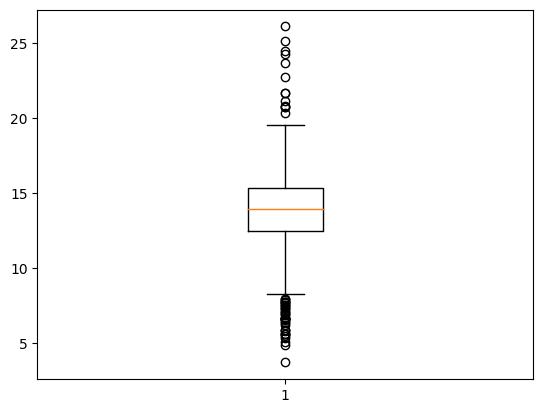

In [85]:
plt.boxplot(outlier.delivery_fee) # boxplot for delivery fee

We can see that some data are out of the upper fence and lower fence, these data are outliers.

In [86]:
# https://www.statology.org/interquartile-range-python/#:~:text=The%20interquartile%20range%2C%20often%20denoted,75th%20percentile)%20of%20a%20dataset.
q3 = np.percentile(outlier.delivery_fee, 75)
q1 = np.percentile(outlier.delivery_fee, 25)
IQR = q3 -q1
print('IQR is ' +str(IQR))

IQR is 2.8655147250000006


In [87]:
upper_fence = q3 + 1.5*IQR
lower_fence = q1 - 1.5*IQR
print('upper_fence is ' + str(upper_fence))
print('lower_fence is ' + str(lower_fence))

upper_fence is 19.663618362500003
lower_fence is 8.201559462499999


In [88]:
# remove outliers
for index, row in outlier.iterrows():
    if row.delivery_fee > upper_fence or row.delivery_fee < lower_fence:
        outlier = outlier.drop(index = index)

In [89]:
outlier.info() # Check after removing outliers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 0 to 498
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 448 non-null    object 
 1   date                     448 non-null    object 
 2   time                     448 non-null    object 
 3   order_type               448 non-null    object 
 4   branch_code              448 non-null    object 
 5   order_items              448 non-null    object 
 6   order_price              448 non-null    float64
 7   customer_lat             448 non-null    float64
 8   customer_lon             448 non-null    float64
 9   customerHasloyalty?      448 non-null    int64  
 10  distance_to_customer_KM  448 non-null    float64
 11  delivery_fee             448 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 45.5+ KB


<div class="alert alert-block alert-warning">
    
## 4.  Output <a class="anchor" name="output"></a>
 </div>

In [90]:
# Remove unnecessary columns
dirty = dirty.drop(['is_weekend','time_of_the_day','predict_fee'],axis = 1)
missing = missing.drop(['is_weekend','time_of_the_day'],axis = 1)

In [91]:
dirty.to_csv('32189222_dirty_data_solution.csv',index = False)
missing.to_csv('32189222_missing_data_solution.csv',index = False)
outlier.to_csv('32189222_outlier_data_solution.csv', index = False)